In [72]:
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.under_sampling import NeighbourhoodCleaningRule 
X, y = make_classification(n_classes=2, class_sep=2,
 weights=[0.1, 0.9], n_informative=3, n_redundant=1, flip_y=0,
 n_features=20, n_clusters_per_class=1, n_samples=1000, random_state=10)
print('Original dataset shape {}'.format(Counter(y)))

ncr = NeighbourhoodCleaningRule()
X_res, y_res = ncr.fit_resample(X, y)
print('Resampled dataset shape {}'.format(Counter(y_res)))

Original dataset shape Counter({1: 900, 0: 100})
Resampled dataset shape Counter({1: 877, 0: 100})


In [74]:
import pickle

pipeline_id = "A652_N"
filename = "../data/datasets/" + pipeline_id + ".pickle"
print(f"Loading train/val/test datasets from {filename}.")
file = open(filename, 'rb')
(X_train, y_train, X_val, y_val, X_test, y_test) = pickle.load(file)
print(f"Shapes of train/val/test data matrices: {X_train.shape}/{X_val.shape}/{X_test.shape}")
print(f"Min values of train/val/test data matrices: {min(X_train.reshape(-1,1))}/{min(X_val.reshape(-1,1))}/{min(X_test.reshape(-1,1))}")
print(f"Max values of train/val/test data matrices: {max(X_train.reshape(-1,1))}/{max(X_val.reshape(-1,1))}/{max(X_test.reshape(-1,1))}")

min(y_train), max(y_train)

Loading train/val/test datasets from ../data/datasets/A652_N.pickle.
Shapes of train/val/test data matrices: (71237, 6, 23)/(20369, 6, 23)/(10219, 6, 23)
Min values of train/val/test data matrices: [0.]/[0.]/[0.]
Max values of train/val/test data matrices: [1.]/[1.]/[1.]


(array([0.]), array([60.8]))

In [75]:
y_train[y_train>0] = 1
y_test[y_test>0] = 1

In [76]:
y_train

array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]])

In [77]:
X_train.shape

(71237, 6, 23)

In [78]:
X_train = X_train.reshape(len(X_train), -1)
X_test = X_test.reshape(len(X_test), -1)

In [79]:
X_train.shape, y_train.shape

((71237, 138), (71237, 1))

In [80]:
X_test.shape, y_test.shape

((10219, 138), (10219, 1))

# Step 1: Train "pilot" model

In [81]:
import numpy as np 
y_eq_zero_idxs = np.where(y_train == 0)[0]
y_gt_zero_idxs = np.where(y_train > 0)[0]
print(f"Ratio between neg/pos examples: {len(y_eq_zero_idxs)}/{len(y_gt_zero_idxs)}")

Ratio between neg/pos examples: 64270/6967


In [82]:
positive_examples = X_train[y_gt_zero_idxs]
negative_examples = X_train[y_eq_zero_idxs]

In [83]:
num_positive_examples = len(positive_examples)
num_negative_examples = len(negative_examples)
desired_num_examples = min(num_positive_examples, num_negative_examples)
print(desired_num_examples)

6967


In [84]:
positive_indices = np.random.choice(num_positive_examples, size=desired_num_examples, replace=False)
negative_indices = np.random.choice(num_negative_examples, size=desired_num_examples, replace=False)

In [85]:
X_balanced = np.concatenate((positive_examples[positive_indices], negative_examples[negative_indices]))
y_balanced = np.concatenate((np.ones(desired_num_examples), np.zeros(desired_num_examples)))

In [86]:
assert len(y_balanced) == 2*6967

In [87]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split

# Create a GradientBoostingClassifier object with default hyperparameters
clf = GradientBoostingClassifier()

# Train the classifier on the training data
clf.fit(X_balanced, y_balanced)

GradientBoostingClassifier()

# Step 2: Score the negative examples with the pilot model

In [88]:
X_balanced_negative = X_balanced[y_balanced==0]
y_balanced_negative = y_balanced[y_balanced==0]

# Get predicted probabilities on the negative samples
y_proba = clf.predict_proba(X_balanced_negative)

# The predicted probabilities for the negative class (class 1) are in the first column
y_proba_negative = y_proba[:, 0]

print(f"Scores for the first 5 negative examples: {y_proba_negative[:5]}")
print(f"Correct labels for the first 5 negative examples: {y_balanced_negative[:5]}")

Scores for the first 5 negative examples: [0.96028869 0.85228002 0.42767954 0.56389382 0.95668975]
Correct labels for the first 5 negative examples: [0. 0. 0. 0. 0.]


# Step 3: Sample the negative examples proportionally to the scores

In [89]:
import numpy as np

# Create an array of indices corresponding to X_balanced_negative
indices = np.arange(len(X_balanced_negative))

# Normalize the probabilities to sum to 1
y_proba_normalized = y_proba_negative / np.sum(y_proba_negative)

# Sample the indices using the probabilities from y_proba
sampled_indices = np.random.choice(indices, size=num_positive_examples, replace=False, p=y_proba_normalized)

# Use the sampled indices to get a subset of X_balanced
X_sampled_negative = X_balanced_negative[sampled_indices]

len(X_sampled_negative)

6967

In [90]:
positive_examples.shape, X_sampled_negative.shape

((6967, 138), (6967, 138))

In [91]:
X_train_sampled = np.concatenate((positive_examples, X_sampled_negative))
y_train_sampled = np.concatenate((np.ones(desired_num_examples), np.zeros(desired_num_examples)))
X_train_sampled.shape, y_train_sampled.shape

((13934, 138), (13934,))

# Train a classifier on the sampled training set

In [92]:
from sklearn.ensemble import GradientBoostingClassifier

# Create a GradientBoostingClassifier object with default hyperparameters
clf = GradientBoostingClassifier()

# Train the classifier on the training data
clf.fit(X_train_sampled, y_train_sampled)

GradientBoostingClassifier()

In [93]:
# Make predictions on the testing data
y_pred = clf.predict(X_test.reshape(len(X_test), -1))

In [94]:
y_true = y_test
y_true[y_true>0] = 1

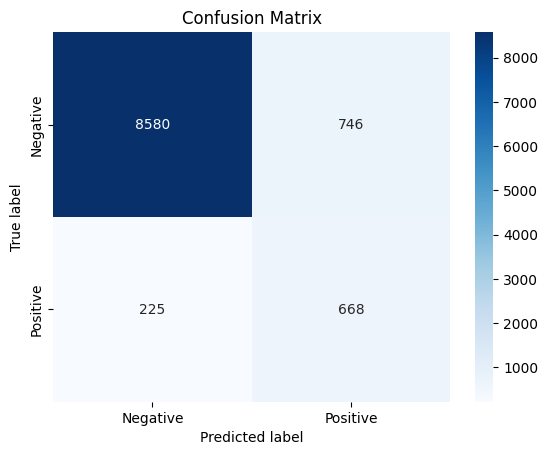

In [95]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Calculate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Define the class labels
class_names = ['Negative', 'Positive']

# Create a heatmap using Seaborn
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

# Add labels and title
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')

# Show the plot
plt.show()

In [96]:
from sklearn.metrics import classification_report

# Build the classification report
target_names = ['Negative', 'Positive']
report = classification_report(y_true, y_pred, target_names=target_names)

# Print the classification report
print(report)

              precision    recall  f1-score   support

    Negative       0.97      0.92      0.95      9326
    Positive       0.47      0.75      0.58       893

    accuracy                           0.90     10219
   macro avg       0.72      0.83      0.76     10219
weighted avg       0.93      0.90      0.91     10219



# Train a classifier on the original training set

In [97]:
from sklearn.ensemble import GradientBoostingClassifier

# Create a GradientBoostingClassifier object with default hyperparameters
clf = GradientBoostingClassifier()

# Train the classifier on the training data
clf.fit(X_train, y_train)

/home/ebezerra/anaconda3/envs/atmoseer/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:570: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GradientBoostingClassifier()

In [98]:
# Make predictions on the testing data
y_pred = clf.predict(X_test.reshape(len(X_test), -1))

In [99]:
y_true = y_test
y_true[y_true>0] = 1

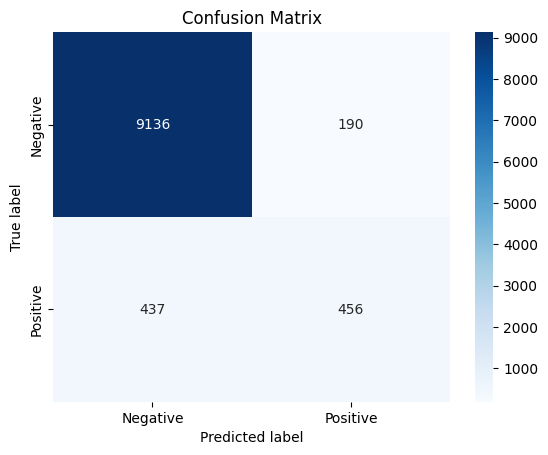

In [100]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Calculate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Define the class labels
class_names = ['Negative', 'Positive']

# Create a heatmap using Seaborn
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

# Add labels and title
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')

# Show the plot
plt.show()

In [101]:
from sklearn.metrics import classification_report

# Build the classification report
target_names = ['Negative', 'Positive']
report = classification_report(y_true, y_pred, target_names=target_names)

# Print the classification report
print(report)

              precision    recall  f1-score   support

    Negative       0.95      0.98      0.97      9326
    Positive       0.71      0.51      0.59       893

    accuracy                           0.94     10219
   macro avg       0.83      0.75      0.78     10219
weighted avg       0.93      0.94      0.93     10219

